In [40]:
from satpy.scene import Scene
from pathlib import Path
import subprocess
from pyresample import geometry

In [25]:
#SOURCE_PATH = Path("/storage/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/raw/EUMETSAT/SEVIRI_RSS/downloaded_manually_and_sorted/2019/06/01/12/04/MSG3-SEVI-MSG15-0100-NA-20190601120416.190000000Z-20190601120433-1358336-1.nat.bz2")
SOURCE_PATH = Path("~/temp/MSG3-SEVI-MSG15-0100-NA-20190601120416.190000000Z-20190601120433-1358336-1.nat.bz2").expanduser()

In [26]:
def decompress(full_bzip_filename: Path) -> Path:
    # --keep: Keep the original .bz2 file (don't delete it)
    # --force: Overwrite the .nat file if it already exists.
    # -m1000: Maximum memory usage in 1MB steps (1000 = 1,000 MB)
    process = subprocess.run(
        ['pbzip2', '--decompress', '--keep', '--force', '-m1000', full_bzip_filename])
    process.check_returncode()
    full_nat_filename = full_bzip_filename.parent / full_bzip_filename.stem
    assert full_nat_filename.exists()
    return full_nat_filename

In [27]:
%%time
full_nat_filename = decompress(SOURCE_PATH)

CPU times: user 2.34 ms, sys: 4.2 ms, total: 6.54 ms
Wall time: 476 ms


In [28]:
str(full_nat_filename)

'/home/jack/temp/MSG3-SEVI-MSG15-0100-NA-20190601120416.190000000Z-20190601120433-1358336-1.nat'

Reading from a MergerFS array will cause numpy's memmap to throw an OS Error:

```python
~/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/numpy/core/memmap.py in __new__(subtype, filename, dtype, mode, offset, shape, order)
    265             bytes -= start
    266             array_offset = offset - start
--> 267             mm = mmap.mmap(fid.fileno(), bytes, access=acc, offset=start)
    268 
    269             self = ndarray.__new__(subtype, shape, dtype=descr, buffer=mm,

OSError: [Errno 19] No such device
```

This isn't a huge problem, because we can read from the underlying ZFS mirrors, which is probably faster, anyway.

In [39]:
%%time

# TODO: Try opening multiple .nat files at once, to see if the 150ms is constant, or scales with the number of files.

scene = Scene(reader='seviri_l1b_native', filenames=[str(full_nat_filename)])

CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 144 ms


In [42]:
# Adapted from https://github.com/openclimatefix/Satip/blob/e46013831071e8e4a4759ca46421d5355c342d1f/satip/reproj.py#L139
projection = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

area_definition = geometry.AreaDefinition.from_area_of_interest(
    area_id="TM",
    projection=projection,
    shape=(64, 64),  # height, width
    center=(1000, 1000),  # x, y
    resolution=4000)  # meters per pixel?!

In [53]:
%%time
scene.load(["HRV"])

CPU times: user 140 ms, sys: 16.8 ms, total: 157 ms
Wall time: 146 ms


In [54]:
%%time
resampled_scene = scene.resample(destination=area_definition)
# TODO: Only use one channel?

/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pyresample/spherical.py:119: RuntimeWarning: invalid value encountered in true_divide
  self.cart /= np.sqrt(np.einsum('...i, ...i', self.cart, self.cart))
/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pyresample/spherical.py:171: RuntimeWarning: invalid value encountered in double_scalars
  return (val + mod) % (2 * mod) - mod


CPU times: user 705 ms, sys: 10.6 ms, total: 715 ms
Wall time: 719 ms


/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [55]:
print(resampled_scene)

<xarray.DataArray 'my_index-3ede33e6cbd2ffd8fea189a002d63468' (y: 64, x: 64)>
dask.array<my_index, shape=(64, 64), dtype=float32, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Unknown ba...
  * y        (y) float64 1.27e+05 1.23e+05 1.19e+05 ... -1.21e+05 -1.25e+05
  * x        (x) float64 -1.25e+05 -1.21e+05 -1.17e+05 ... 1.23e+05 1.27e+05
Attributes: (12/19)
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0280062341635272
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    ...                                     ...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:          

/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


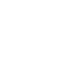

In [56]:
resampled_scene.show("HRV")